# Visualizing Data from Data Warehouse
Now that we have our database populated with our data in the appropriate format, we're going to create some basic visualizations for demonstration purposes. For consistency, we'll focus on just information from the 2015 trees census.

First we'll create our database connection and load some necessary libraries. 

In [1]:
# Change to 'warn=0' to display warnings if something isn't running correctly!
options(warn=-1)

library(DBI)
library(RPostgres)
library(ggplot2)
library(forcats)

con = dbConnect(
  drv = RPostgres::Postgres(),
  host = "localhost",
  port = 5432,
  # Please don't use plain text password in production :)
  user = "postgres",
  password = "secure_p4ssw0rd",
  dbname = "postgres"
)

Now we'll just pull in the data that was already presented in some of the views we created in our database.

In [2]:
trees = dbGetQuery(con, 'SELECT * FROM nyctrees.trees')
locations = dbGetQuery(con, 'SELECT * FROM nyctrees.locations')
census = dbGetQuery(con, 'SELECT * FROM nyctrees.neighborhood_census')

## 'Trees' Database View

In [3]:
head(trees)

genus,species,healthstatus,infguard,infshoes,sidwcrack,year,ntanamefull,tree_dbh
tilia,cordata,Poor,FALSE,FALSE,FALSE,2005,Westchester-Unionport,3
acer,saccharum,Poor,FALSE,FALSE,FALSE,2005,Van Nest-Morris Park-Westchester Square,17
acer,saccharinum,Poor,FALSE,FALSE,FALSE,2015,Van Nest-Morris Park-Westchester Square,16
zelkova,serrata,Poor,FALSE,FALSE,FALSE,2005,Soundview-Bruckner,3
zelkova,serrata,Poor,FALSE,FALSE,FALSE,2005,Soundview-Castle Hill-Clason Point-Harding Park,4
zelkova,serrata,Poor,FALSE,FALSE,FALSE,2015,Westchester-Unionport,3


We can see from the output above that our dataframe is consistent with what we would expect from the 'trees' view in our database

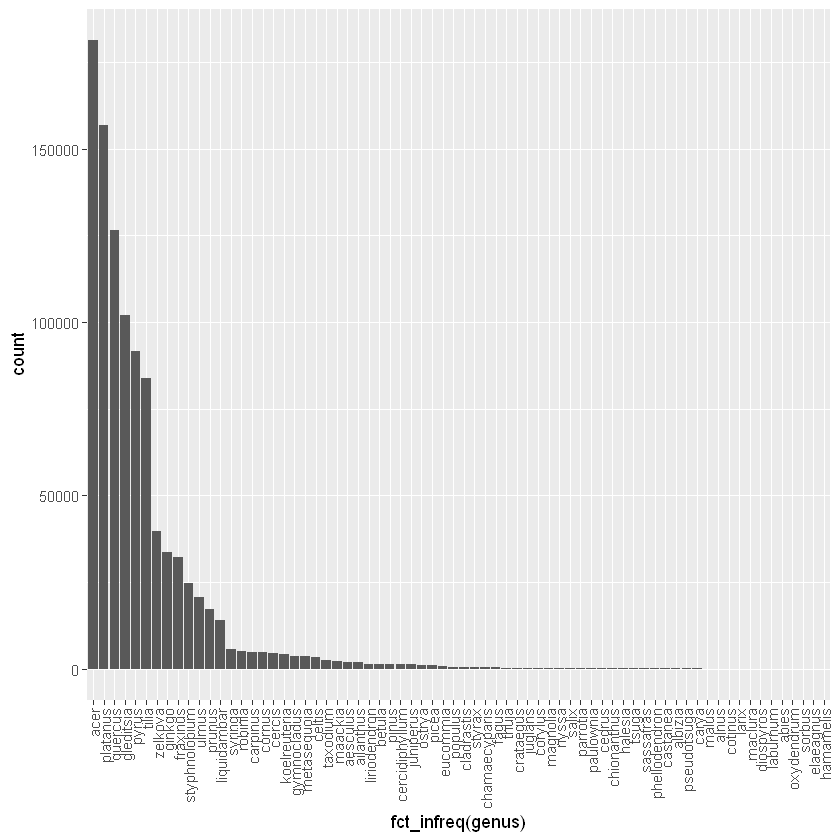

In [4]:
ggplot(data=trees, aes(x=fct_infreq(genus))) + geom_bar(stat="count") + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

Our initial graph is pretty lopsided, with several genera only having a fraction of entries compared to some of our more populous entries. We'll fix this by limiting our query to the top 15 genera.

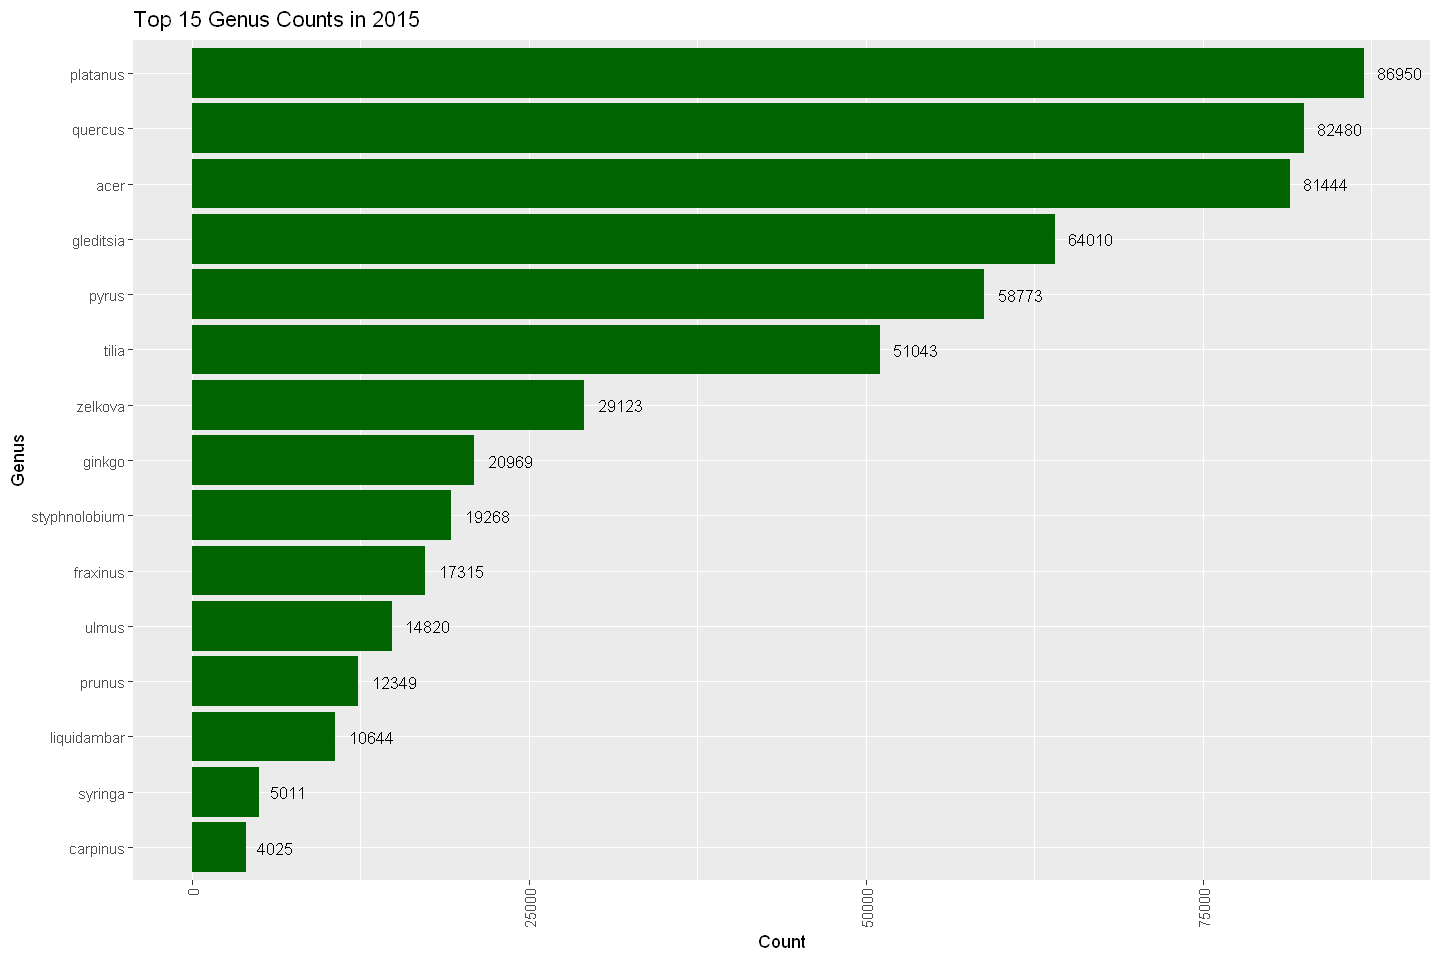

In [5]:
top_genus = dbGetQuery(con, 'SELECT genus, COUNT(genus) FROM nyctrees.trees WHERE year = 2015 GROUP BY genus  ORDER BY COUNT(genus) DESC LIMIT 15')

options(repr.plot.width=12, repr.plot.height=8)
ggplot(data=top_genus, aes(x=reorder(genus, count), count)) + 
  coord_flip() +
  geom_bar(stat="identity", fill="darkgreen") + 
  geom_text(aes(label=as.integer(count)), hjust=-0.3, size=3.5) +
  scale_y_continuous(limits=c(0,87500)) + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
  labs(title="Top 15 Genus Counts in 2015", y="Count", x="Genus")


While this plot is still pretty dominated by the first few entries, it helps us focus on the more common genera in our dataset. 

Now we'll look on step down the taxonomic rank - species! We'll start by taking the first 15 here as well as our result will likely be similar to the genera plot above if we plotted each species. 

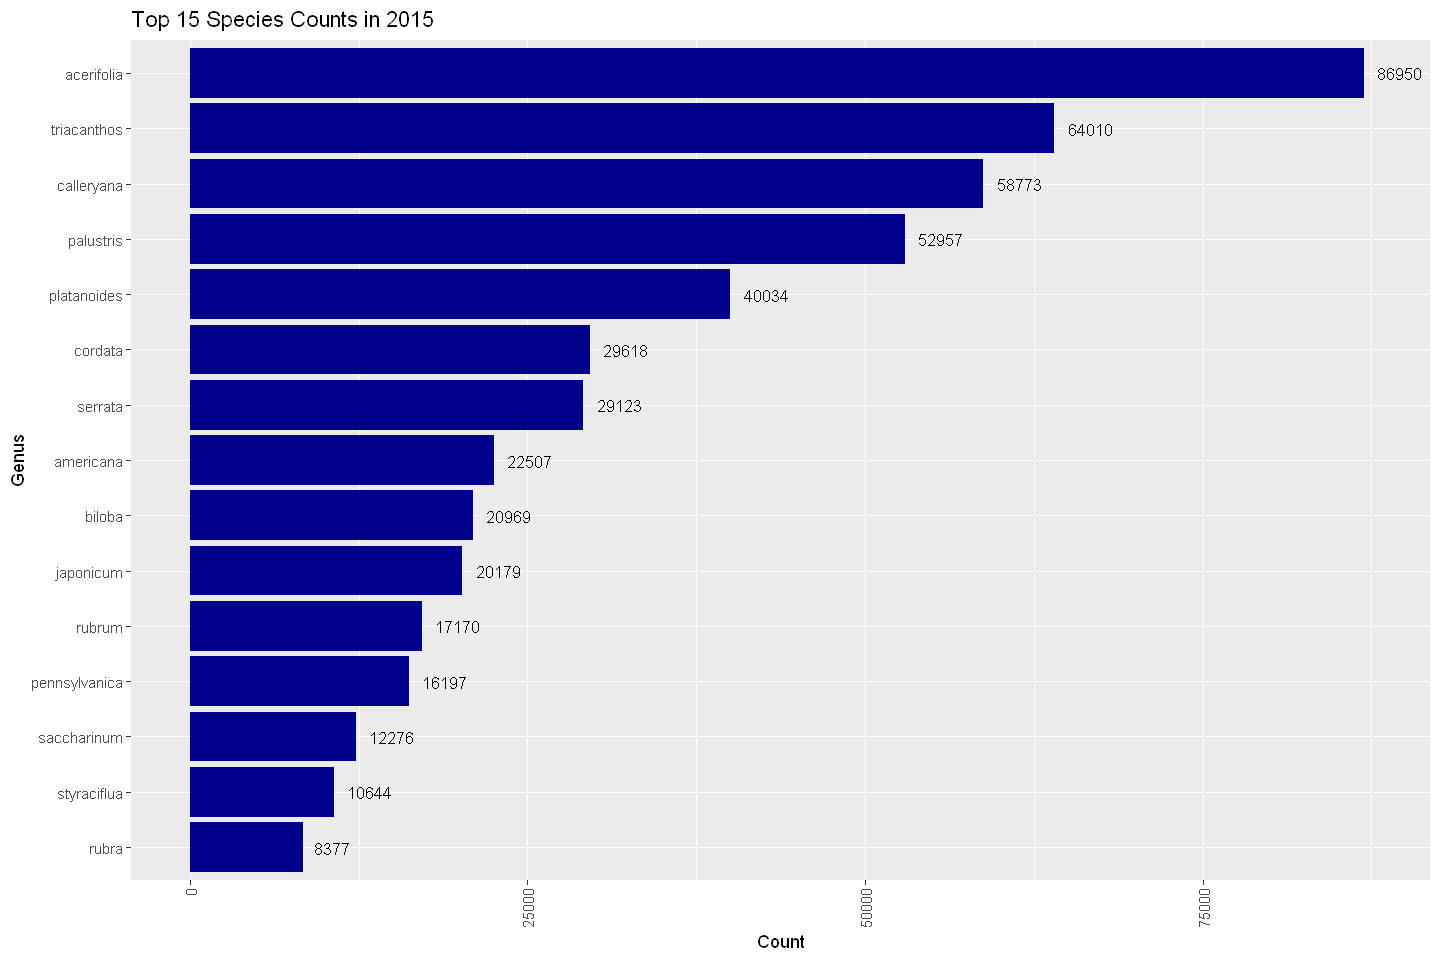

In [6]:
top_species = dbGetQuery(con, 'SELECT species, COUNT(species) FROM nyctrees.trees WHERE year = 2015 GROUP BY species ORDER BY COUNT(species) DESC LIMIT 15')

ggplot(data=top_species, aes(x=reorder(species, count), count)) + 
  coord_flip() +
  geom_bar(stat="identity", fill="darkblue") + 
  geom_text(aes(label=as.integer(count)), hjust=-0.3, size=3.5) +
  scale_y_continuous(limits=c(0,87500)) + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
  labs(title="Top 15 Species Counts in 2015", y="Count", x="Genus")

It's interesting to note that the highest genus and highest species both share the same tree count. This could be a future point of investigation! 

Now we'll look at the species breakdown by one of the neighborhoods in our data, the 'Annadale-Huguenot-Prince's Bay-Eltingville' neighborhood.

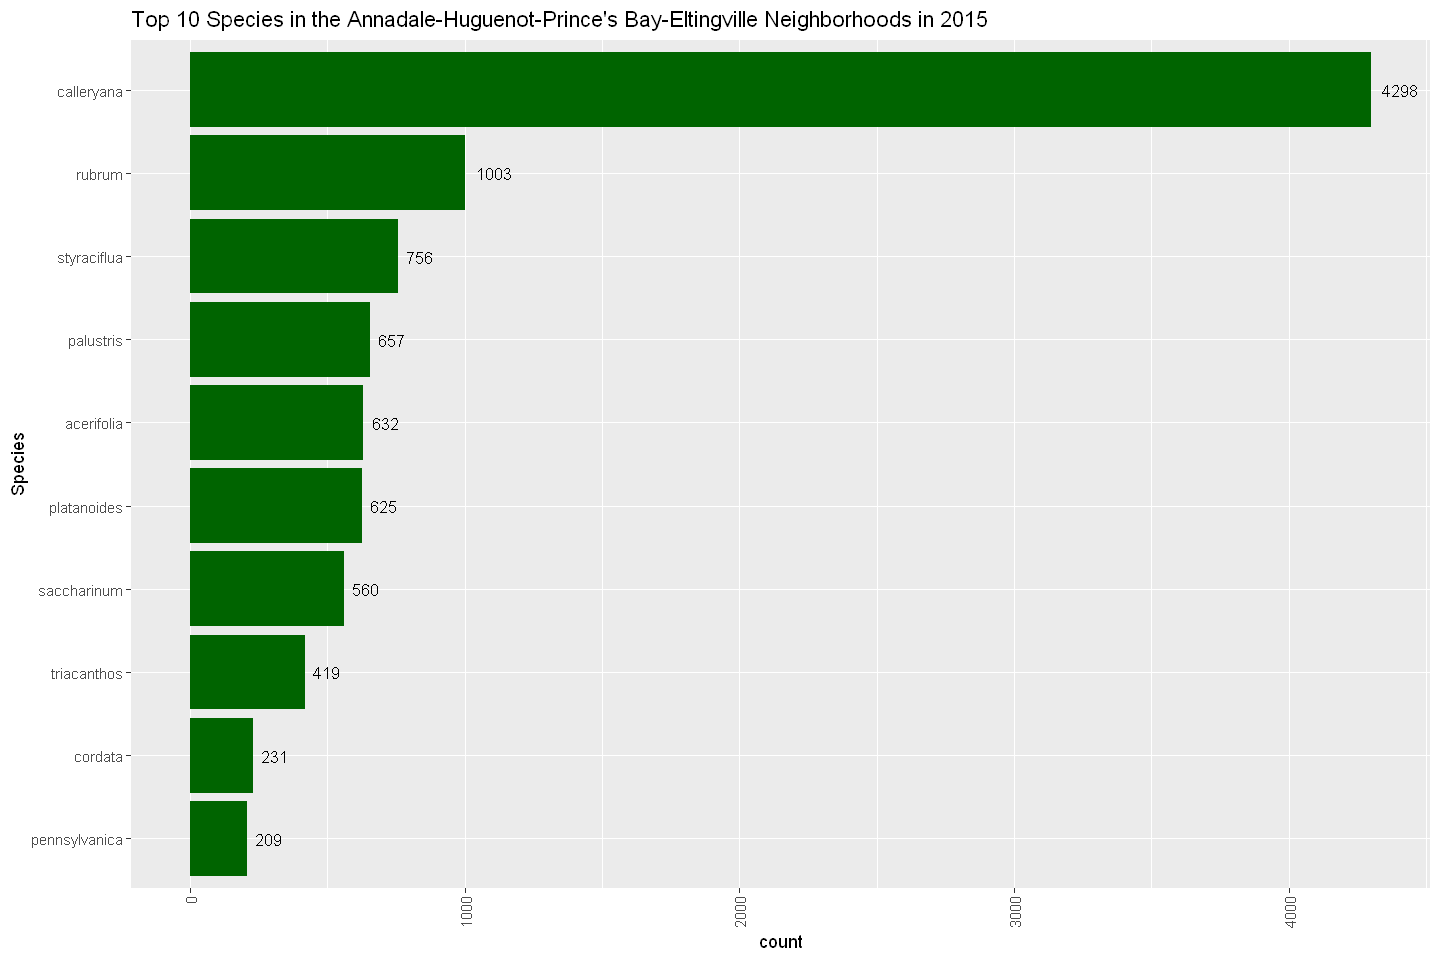

In [7]:
annadale_species = dbGetQuery(con, "SELECT species, COUNT(species) FROM nyctrees.trees WHERE year = 2015 AND ntanamefull = 'Annadale-Huguenot-Prince''s Bay-Eltingville' GROUP BY species ORDER BY COUNT(species) DESC LIMIT 10")

ggplot(data=annadale_species, aes(x=reorder(species, count), y=count)) + 
  geom_bar(stat="identity", fill="darkgreen") +
  geom_text(aes(label=as.integer(count)), hjust=-0.3, size=3.5) +
  scale_y_continuous(limits=c(0,4300)) + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  labs(title="Top 10 Species in the Annadale-Huguenot-Prince's Bay-Eltingville Neighborhoods in 2015", y="count", x="Species") + 
  coord_flip()

Based on the plot above, we can see that the 'calleryana' species is by far the most populous for this neighborhood!

Now we'll look at the general distribution of the diameter of our trees. 

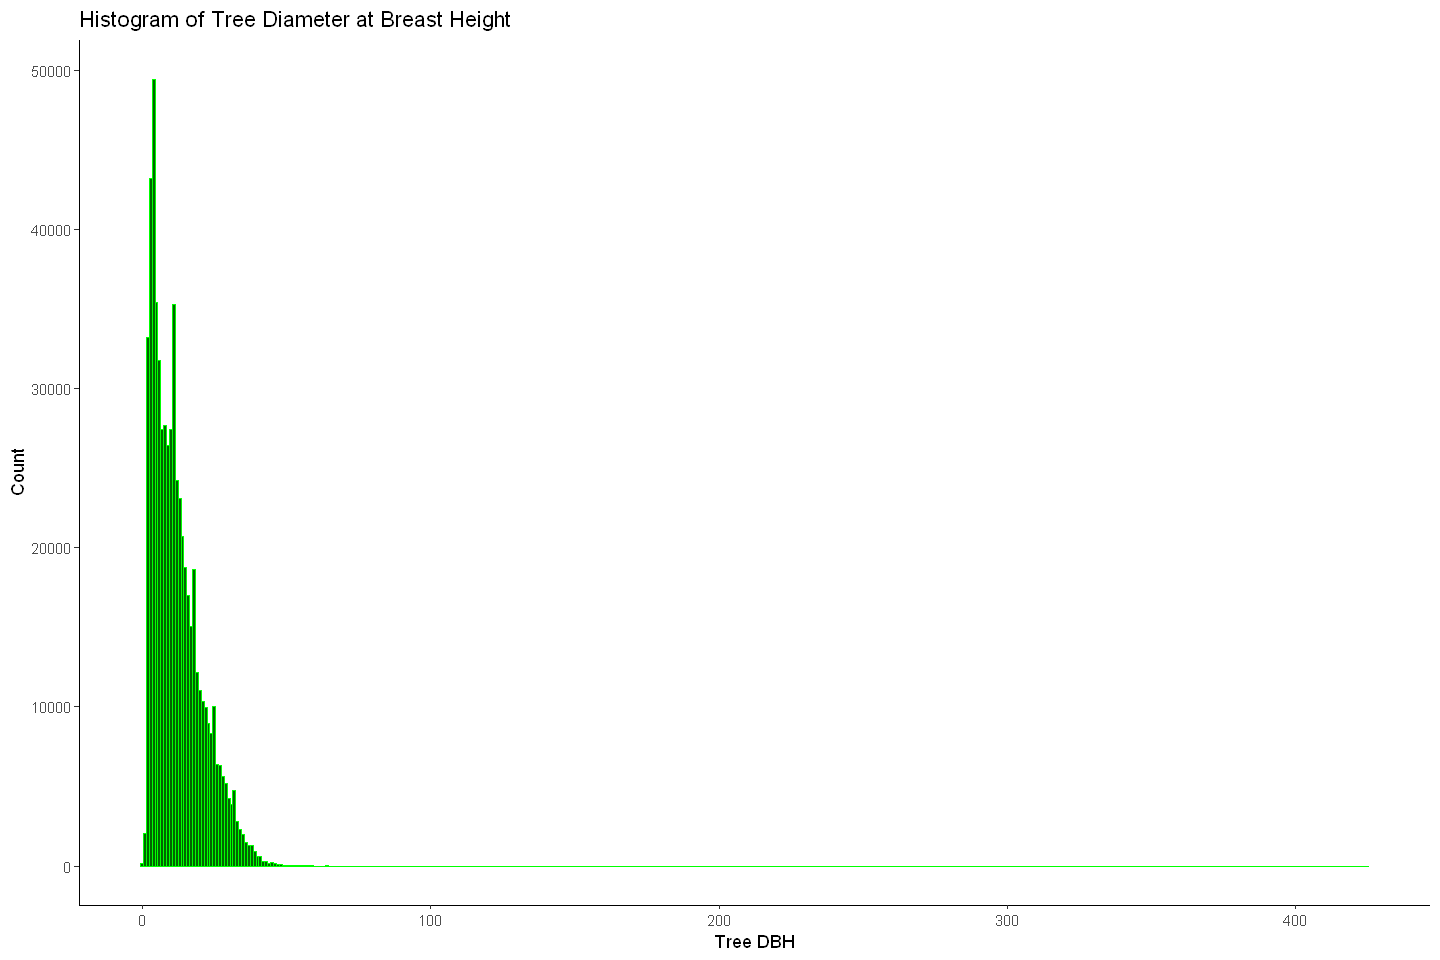

In [8]:
dbh_dist = dbGetQuery(con, 'SELECT  tree_dbh FROM nyctrees.trees WHERE year = 2015 ')

ggplot(data=dbh_dist, aes(x=dbh_dist$tree_dbh)) + 
  geom_histogram(color="green", fill="darkgreen", binwidth = 1) +
  labs(title="Histogram of Tree Diameter at Breast Height", y="Count", x="Tree DBH") + 
  theme_classic()

We can tell based on this graph that we have some pretty heavy outliers. Since these entries are supposed to be measured in inches, these are likely entered in error. Regardless, we'll focus on just the 'standard' distribution and only focus on the trees with a diameter within 3 standard deviations. 

In [9]:
dbGetQuery(con, "SELECT 3*stddev(tree_dbh) as data_range FROM nyctrees.trees AS t (stddev) WHERE year = 2015")

data_range
26.16725


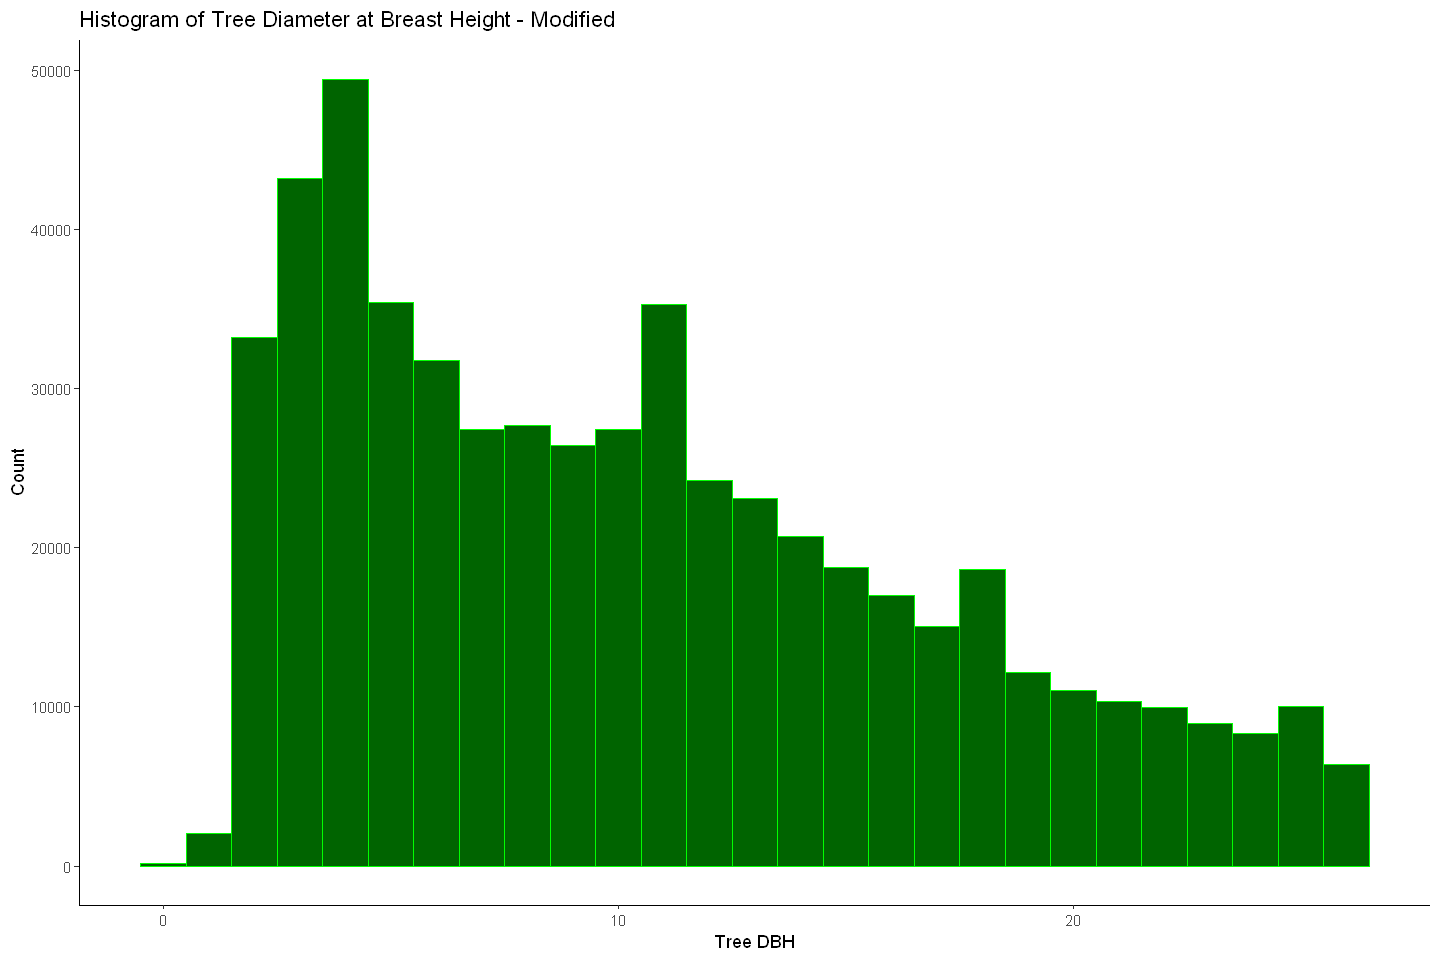

In [10]:
dbh_dist = dbGetQuery(con, 'SELECT  tree_dbh FROM nyctrees.trees WHERE year = 2015 AND tree_dbh < 27')

ggplot(data=dbh_dist, aes(x=dbh_dist$tree_dbh)) + 
  geom_histogram(color="green", fill="darkgreen", binwidth = 1) +
  labs(title="Histogram of Tree Diameter at Breast Height - Modified", y="Count", x="Tree DBH") + 
  theme_classic()

After adjusting our scope, we can see that our data is tapering off based on diameter, which is consistent with what we might expect. 

## 'Locations' Database View
Now we'll look at the second view we've created in our database - the 'locations' view that focus on geographic data for our trees. We can see from the first few entries below that our dataframe is consistent with what we'd expect out of our database. 

In [11]:
head(locations)

genus,species,zipcity,zipcode,stassem,stsenate,cncldist,boroct,borocode,year,longitude,latitude,x_sp,y_sp
tilia,cordata,Bronx,10462,87,34,13,2009600,2,2005,40.82898,-73.84403,1027414,241337.0
acer,saccharum,Bronx,10462,87,34,13,2025600,2,2005,40.84302,-73.85306,1024905,246447.0
acer,saccharinum,Bronx,10461,87,34,13,2025600,2,2015,40.84419,-73.85147,1025347,246872.1
zelkova,serrata,Bronx,10472,87,34,18,2004001,2,2005,40.82735,-73.85739,1023717,240737.0
zelkova,serrata,Bronx,10473,87,34,18,2009000,2,2005,40.81949,-73.84442,1027312,237879.0
zelkova,serrata,Bronx,10472,87,34,18,2007800,2,2015,40.83078,-73.85324,1024864,241986.7


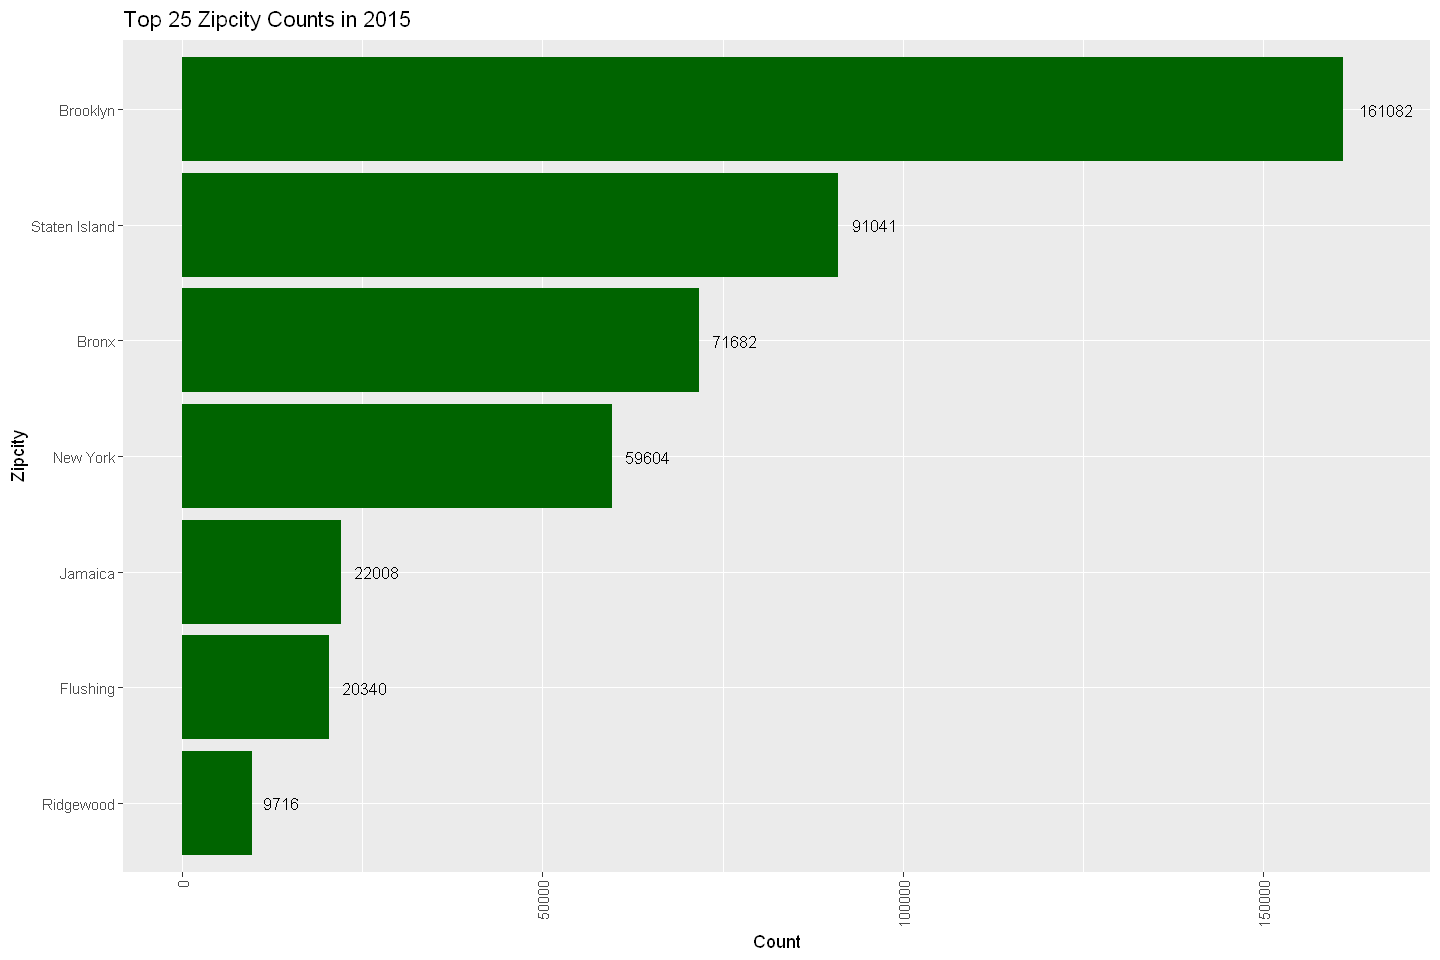

In [12]:
top_zipcity = dbGetQuery(con, 'SELECT zipcity, COUNT(zipcity) FROM nyctrees.locations WHERE year=2015 GROUP BY zipcity ORDER BY COUNT(zipcity) DESC LIMIT 7')

ggplot(data=top_zipcity, aes(x=reorder(zipcity, count), y=count)) + 
  geom_bar(stat="identity", fill="darkgreen") + 
  geom_text(aes(label=as.integer(count)), hjust=-0.3, size=3.5) +
  scale_y_continuous(limits=c(0,165000)) + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  labs(title="Top 25 Zipcity Counts in 2015", y="Count", x="Zipcity") +
  coord_flip()

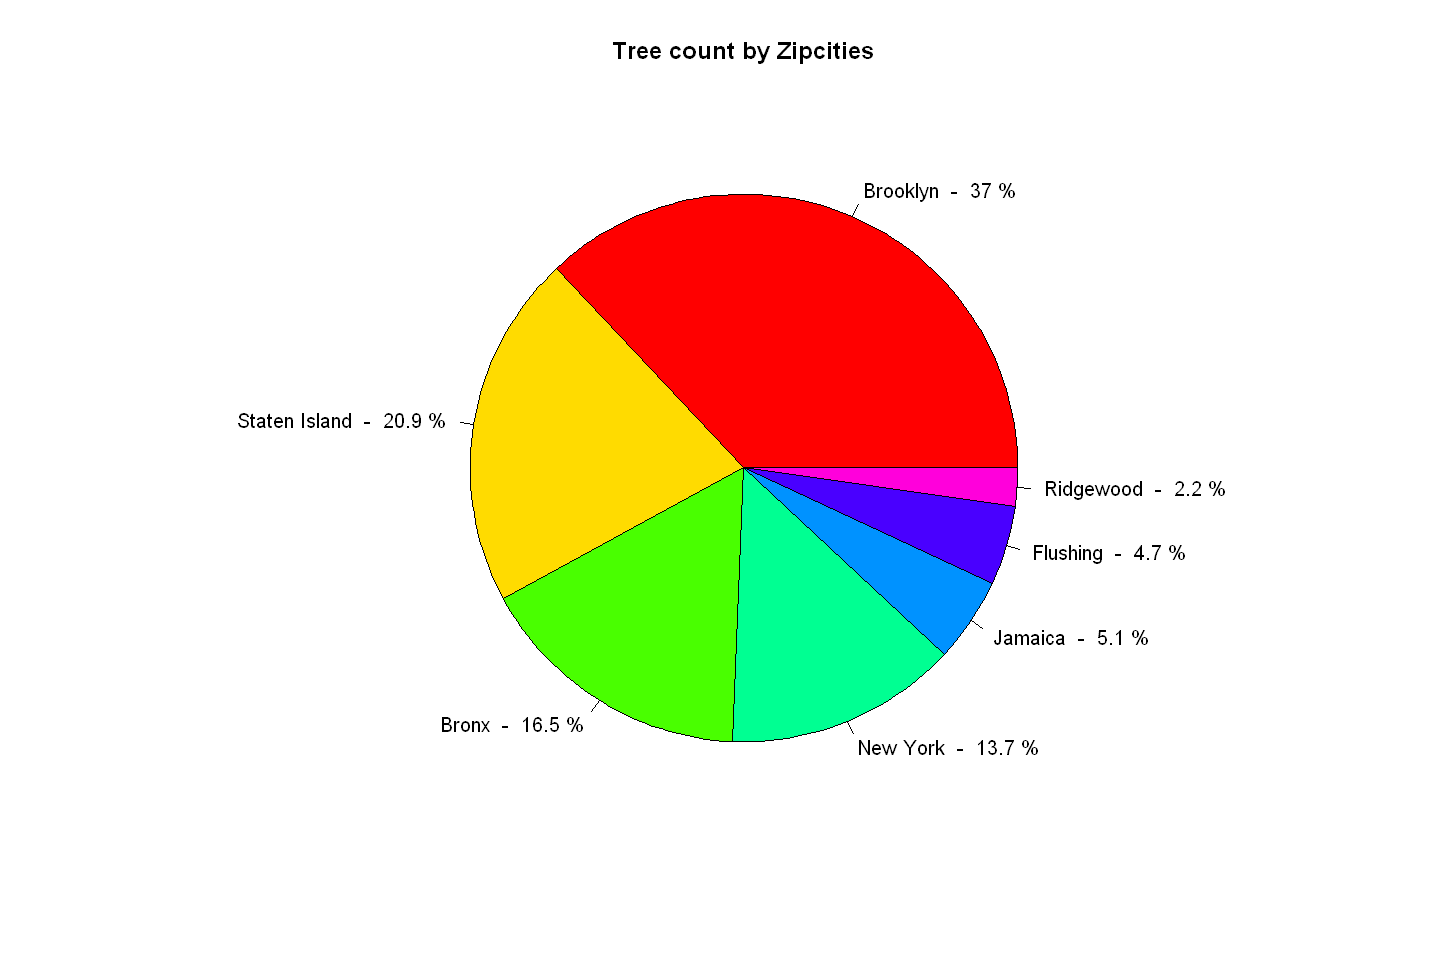

In [13]:
zip_labs = paste(top_zipcity$zipcity, " - ", round(100*top_zipcity$count/sum(top_zipcity$count), 1), "%")
pie(top_zipcity$count, labels=zip_labs, col=rainbow(length(top_zipcity$zipcity)), main= "Tree count by Zipcities")

Above is just a brief look into the tree distribution across neighborhoods in 2015. We can see that there are several neighborhoods that have a large percentage of trees in NYC. 

## 'Neighborhood Census' Database View
Now we'll take a very brief look at our last view that was created for our database. 

In [14]:
head(census)

ntaname,year,income,education,population,unemployment,popdensity,laborforce,poverty,diversity
Astoria,2005,46660.00,0.2921942,196854,0.07532848,36.90527,0.6411879,0.1834740,5.192308
Astoria,2015,60574.10,0.4619850,175460,0.06104630,34.03680,0.6955960,0.1671530,4.556452
Bay Ridge,2005,60180.00,0.3554819,124339,0.09017288,32.06807,0.6444345,0.1389990,5.741379
Bay Ridge,2015,67610.52,0.4215370,122418,0.07724150,31.80076,0.6237490,0.1391030,5.076923
Bayside/Little Neck,2005,81950.00,0.4319591,111573,0.04591309,12.65898,0.6158456,0.0596264,3.542424
Bayside/Little Neck,2015,83199.85,0.4248140,113563,0.06203340,12.20532,0.6290580,0.0866674,4.411765


After we look at the first few entries in our view and confirm the data is as expected, we can create a simple graph exploring this data some more. Our graph will just look at the distribution of the 'education' attribute, which shows the percentage of individuals above age 25 that have a Bachelor's degree or higher. 

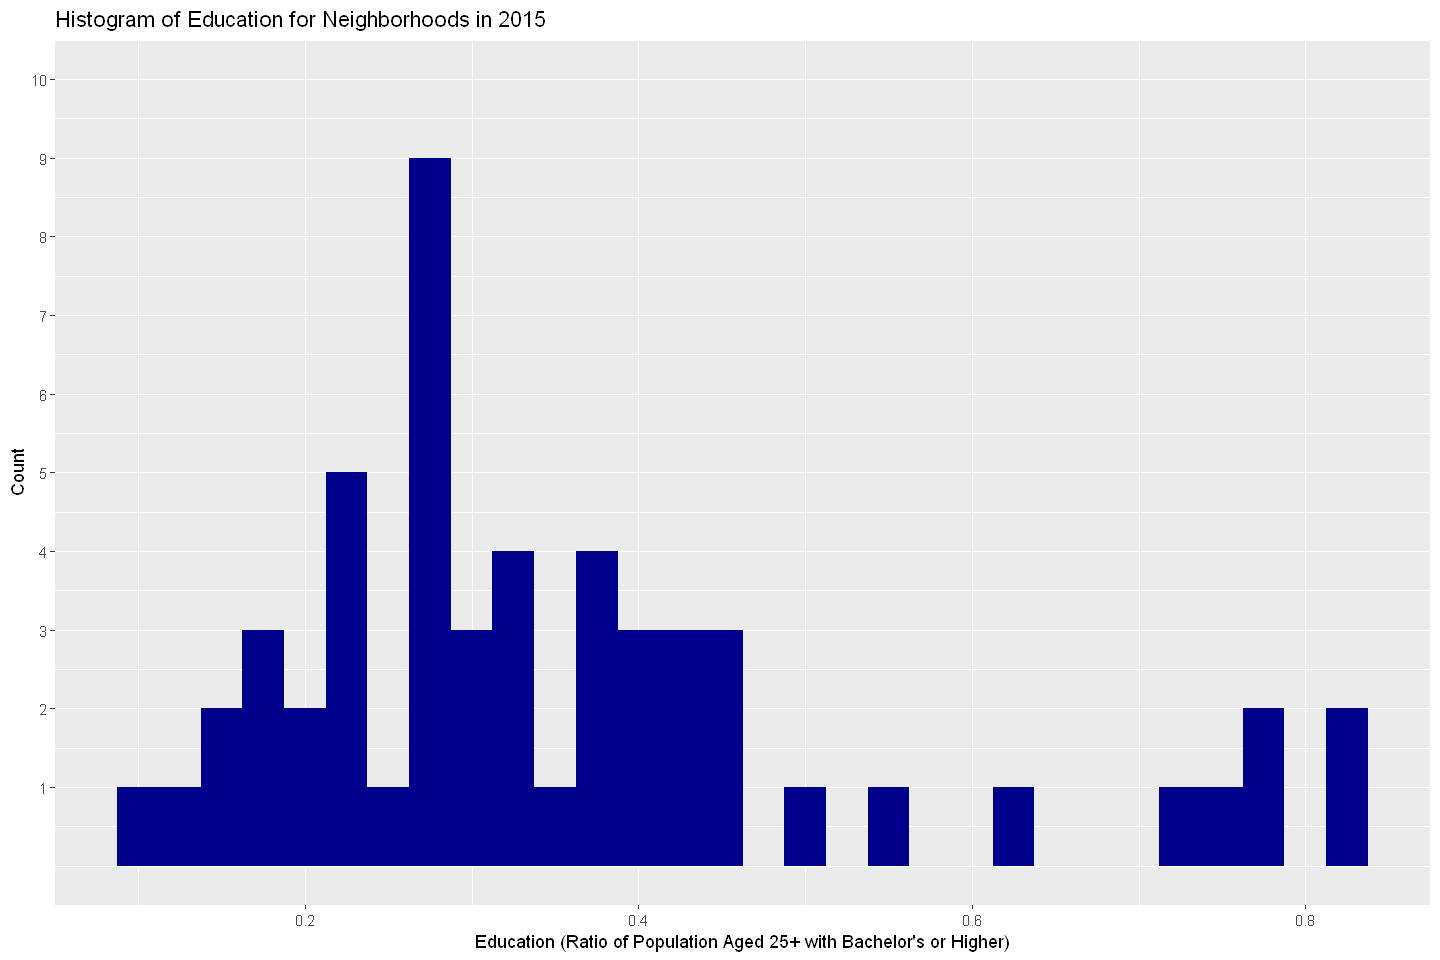

In [15]:
education_distribution = dbGetQuery(con, 'SELECT education FROM nyctrees.neighborhood_census WHERE year=2015')

ggplot(data=education_distribution, aes(x=education)) +
  geom_histogram(binwidth=0.025, fill="darkblue") + 
  scale_y_continuous(limits=c(0,10), breaks=1:10) +
  labs(title="Histogram of Education for Neighborhoods in 2015", y="Count", x="Education (Ratio of Population Aged 25+ with Bachelor's or Higher)")

Finally, with our graphs created we can close our connection to the database. 

In [16]:
dbDisconnect(con)

# Review

Below is a quick recap of the steps that we took during this project to get the data to its final form:
- We created a docker-compose file that created a PostgreSQL database with a pgadmin front end
- We designed a star schema in our database that would have one central fact table and other ancillary tables to lookup values as needed
- We imported the data into the ancillary tables
- We populated the fact table while mapping it to the ancillary tables
- We created several views based on our fact table
- We queried these views in R and created several visualizations

Another important aspect in doing this was the reduced space of our final database compared to our original CSV file. Our original CSV file is ~281 MB while our database is only ~140 MB. This is accomplished by all of the ancillary lookup tables. The use of these tables for the 'Neighborhood Specific' and 'Neighborhood Broad' attributes specifically is likely responsible for a majority of this data reduction. Being able to replace strings with integers will go far in reducing storage requirements! 